# efficientnet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import time


from PIL import Image
import matplotlib.pyplot as plt

# CUDA ni tekshirish

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
    print(f"GPU mavjud: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")  # CPU
    print("GPU mavjud emas, CPU ishlatiladi.")
    
torch.cuda.empty_cache()   # Xotiradan bo‘shatish

GPU mavjud: NVIDIA GeForce RTX 3060


# Transformatsiyalar

In [7]:
# Transformatsiyalar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Ma'lumotlar to'plamini yuklash
train_dataset = datasets.ImageFolder(root='fer_2013_new/train', transform=transform)
val_dataset = datasets.ImageFolder(root='fer_2013_new/test', transform=transform_val)

# DataLoader yaratish
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Modelni tanlash va moslashtirish

In [8]:
def get_model(model_name, num_classes=7):
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    
    return model

Train va Validation funksiyalari

In [9]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

Asosiy train loop

In [10]:
res_val_loss = []
res_val_acc = []
res_train_acc = []
res_train_loss = []

def main(model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    num_epochs = 15
    best_val_acc = 0.0  # Eng yaxshi validation accuracy ni saqlash uchun

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        epoch_time = time.time() - start_time

        # Har bir epoch natijalarini chiqarish
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%, "
              f"Time: {epoch_time:.2f}s")
        res_val_acc.append(val_acc)
        res_val_loss.append(val_loss)
        res_train_acc.append(train_acc)
        res_train_loss.append(train_loss)
        # Har bir epochda modelni saqlash
        torch.save(model.state_dict(), f'{model_name}_model_epoch_{epoch+1}.pth')
        print(f"Model saved as model_epoch_{epoch+1}.pth")

        # Eng yaxshi modelni saqlash
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"New best model saved with Val Accuracy: {best_val_acc:.2f}%")


Asosiy ishga tushirish

# efficientnet da

In [11]:
model_name = 'efficientnet'  # 'efficientnet'
main(model_name)

c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.6021, Train Accuracy: 40.14%, Val Loss: 1.3171, Val Accuracy: 51.91%, Time: 686.45s
Model saved as model_epoch_1.pth
New best model saved with Val Accuracy: 51.91%
Epoch 2/15, Train Loss: 1.2541, Train Accuracy: 53.46%, Val Loss: 1.1411, Val Accuracy: 58.83%, Time: 272.02s
Model saved as model_epoch_2.pth
New best model saved with Val Accuracy: 58.83%
Epoch 3/15, Train Loss: 1.1326, Train Accuracy: 58.38%, Val Loss: 1.0474, Val Accuracy: 61.19%, Time: 270.88s
Model saved as model_epoch_3.pth
New best model saved with Val Accuracy: 61.19%
Epoch 4/15, Train Loss: 1.0631, Train Accuracy: 60.61%, Val Loss: 0.9939, Val Accuracy: 62.33%, Time: 227.88s
Model saved as model_epoch_4.pth
New best model saved with Val Accuracy: 62.33%
Epoch 5/15, Train Loss: 1.0147, Train Accuracy: 62.03%, Val Loss: 0.9588, Val Accuracy: 63.73%, Time: 203.10s
Model saved as model_epoch_5.pth
New best model saved with Val Accuracy: 63.73%
Epoch 6/15, Train Loss: 0.9742, Train Accuracy: 64

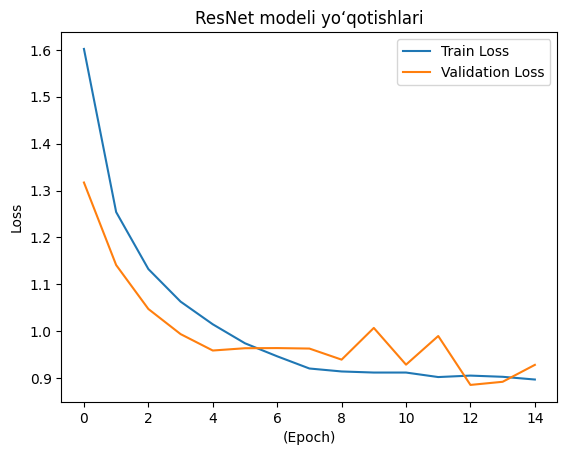

In [12]:
plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('efficientnet modeli yo‘qotishlari')
plt.show()

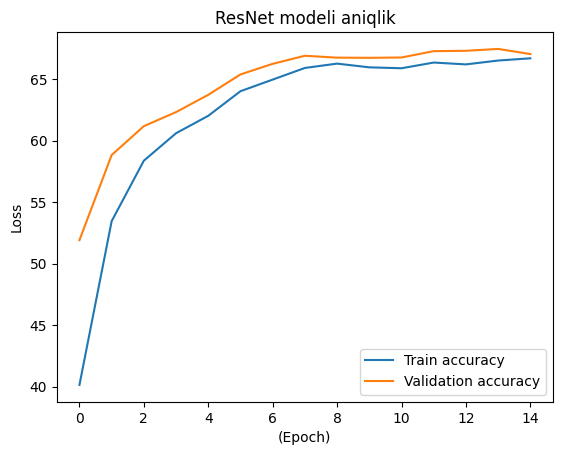

In [13]:
plt.plot(res_train_acc, label='Train accuracy')
plt.plot(res_val_acc, label='Validation accuracy')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('efficientnet modeli aniqlik')
plt.show()